<img src='data/images/lecture-notebook-header.png' />

# Constituency Parsing

Constituency parsing, also known as syntactic parsing or phrase-structure parsing, is an NLP technique that analyzes the grammatical structure of a sentence. It aims to determine the syntactic relationships between words in a sentence and represents them in a hierarchical structure called a parse tree or a constituency tree.

In constituency parsing, a sentence is divided into constituent phrases, which are groups of words that function together as a single unit within the sentence. The parse tree represents the hierarchical structure of these constituents, where the root of the tree represents the entire sentence, and the branches and leaves represent the constituents and words, respectively.

The parse tree is typically generated using a formal grammar such as a context-free grammar (CFG) or a phrase-structure grammar. The parsing algorithm analyzes the sentence by applying grammar rules and assigning labels to the constituents based on their syntactic roles, such as noun phrases, verb phrases, prepositional phrases, and so on.

Constituency parsing can provide valuable information about the sentence's structure, which can be useful in various NLP applications such as machine translation, information extraction, sentiment analysis, and question answering. It helps in understanding the relationships between words and provides a foundation for further semantic analysis and understanding of natural language text.

In the notebook about the CYK algorithm, we focused on this important algorithm to perform constituency parsing. In this notebook, we look at how we can use off-the-shelf tools to perform constituency parsing, as well as consider a simple application that utilizes resulting parse trees. More specifically, use the information about the sentence structure to remove specific parts of the sentence while maintaining it grammatical correctness.

**Disclaimer:** Getting this notebook to run properly might by a bit tricky because of 2 issues:

* spaCy does not support constituency parsing out of the box. You therefore need to install the aftermarket component [Berkeley Neural Parser](https://spacy.io/universe/project/self-attentive-parser); this should be straightforward but might first result in some errors that need to be fixed. While NLTK performs constituency parsing, it is good to have a working solution with spaCy as well, as it is not unlikely that you work more with spaCy in practice.

* Since spaCy has no native in-built constituency parse it does not provide a suitable [visualizer](https://spacy.io/usage/visualizers). While this is not needed for subsequent processing steps, visualizing constituency parse trees can be useful when creating figures of a report or presentation slides. So a lot of the code below is actually only to draw the parse trees in a Jupyter notebook.


## Setting up the Notebook

### Import Required Packages

The code cell below was only needed for the drawing of the constituency parse trees, as this notebook was created on a remote server. Without this cell, trying to draw a parse tree (see below) will yield the error `TclError: no display name and no $DISPLAY environment variable` (see [here](https://stackoverflow.com/questions/37604289/tkinter-tclerror-no-display-name-and-no-display-environment-variable) or [here](https://github.com/jupyterlab/jupyterlab/issues/9660)).

If you run this notebook on your local machine, this should not be necessary. But again, if you can't get this to work, no worries as this is purely for visualization.


In [1]:
import os

os.system('Xvfb :1 -screen 0 1600x1200x16  &')    # create virtual display with size 1600x1200 and 16 bit color. Color can be changed to 24 or 8
os.environ['DISPLAY']=':1.0'

Ignoring the visualization of parse trees, we only need `spacy` and `benepar` (as the component to allow spaCy to perform constituency parsing).

Benepar for SpaCy is an integration of the Berkeley Neural Parser (Benepar) with the SpaCy library. Benepar is a state-of-the-art constituency parsing model developed by researchers at the University of California, Berkeley. It provides accurate and efficient parsing of sentences into syntactic parse trees.

The integration of Benepar with SpaCy allows users to leverage the power of Benepar's parsing capabilities within the SpaCy NLP framework. SpaCy is a popular open-source library for natural language processing that provides various NLP functionalities, including tokenization, part-of-speech tagging, named entity recognition, and dependency parsing. With the Benepar for SpaCy integration, you can perform constituency parsing using Benepar's neural model seamlessly within the SpaCy pipeline. It allows you to generate parse trees that represent the hierarchical structure of sentences, capturing the syntactic relationships between words and phrases.

By incorporating Benepar into SpaCy, you can benefit from the efficiency and ease of use provided by SpaCy while obtaining high-quality constituency parsing results from Benepar's state-of-the-art model. This integration allows for enhanced syntactic analysis and can be useful in a wide range of NLP applications, including text understanding, information extraction, and semantic analysis.

In [2]:
import spacy, benepar

# Load language model
nlp = spacy.load('en_core_web_md')

# Add constuency parser to pipeline (assume a recent version of spaCy)
nlp.add_pipe('benepar', config={'model': 'benepar_en3'})

If the code cell above throws an error that refers to the `protobuf` package, you might need to downgrade it using the following command:

```
pip install protobuf==3.20.*
```

While spaCy does the actual parsing, we need some components from NLTK but purely for visualizing the parse trees.

In [3]:
from nltk.tree import Tree
from nltk.draw import TreeWidget
from nltk.draw.util import CanvasFrame

from IPython.display import Image, display

---

## Perform Constituency Parsing

With `benepar` constituency parser as a component of spaCy, getting a parse tree -- or multiple parse trees in case of multiple sentences -- is very easy. Simply speaking, we use spaCy the same way as usual, with the only difference that the analyzed document now also contains information about the constituency parse. In the code cell below, we provide a series of example sentences, but you are of course welcome to try your own sentences and inspect the resulting parse trees.


In [4]:
text = "Chris likes eating burger."
#text = "I saw the man with a telescope."
#text = "I stayed at the Kempinsky Hotel with Alice."
#text = "The castle in Camelot remained the residence of the king until 536 when he moved it to London"
#text = "Basel was the birthplace of Leonhard Euler, but St. Petersburg was where he died"

doc = nlp(text)

# Let's consider only the first sentence (in case there are more than 1 sentence)
sentence = list(doc.sents)[0]

# The parse string is some standardized way to "verbalize" parse trees using a nested notation
print(sentence._.parse_string)

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/home/vdw/env/anaconda3/envs/cs5246/lib/python3.10/site-packages/torch/distributions/distribution.py:53: UserWarning: <class 'torch_struct.distributions.TreeCRF'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


(S (NP (NNP Chris)) (VP (VBZ likes) (S (VP (VBG eating) (NP (NN burger))))) (. .))


## Visualization of Parse Trees

We can now use this parse string to convert it into an internal tree representation of NLTK, which we only need for visualization.

In [5]:
tree = Tree.fromstring(sentence._.parse_string)

print(tree)

(S
  (NP (NNP Chris))
  (VP (VBZ likes) (S (VP (VBG eating) (NP (NN burger)))))
  (. .))


The method below does all the magic to visualize a constituency parse tree within a Jupyter notebook. The required core components are `CanvasFrame` and `TreeWidget`, which indeed cause all the hassle to get this to work. Notice how the frame first gets exported to a `.ps` file, then converted into a `.png` file, which is finally displayed in the notebook.

In [6]:
def jupyter_draw_nltk_tree(tree, height=40, width=60):
    cf = CanvasFrame()
    tc = TreeWidget(cf.canvas(), tree)
    tc['node_font'] = 'arial 26 bold'
    tc['leaf_font'] = 'arial 26'
    tc['node_color'] = '#003D7C'
    tc['leaf_color'] = '#CC0000'
    tc['line_color'] = '#175252'
    tc['xspace'] = width
    tc['yspace'] = height
    cf.add_widget(tc, 1, 1)
    cf.print_to_file('data/tmp/tmp_tree_output.ps')
    cf.destroy()
    os.system('convert data/tmp/tmp_tree_output.ps data/tmp/tmp_tree_output.png')
    display(Image(filename='data/tmp/tmp_tree_output.png'))
    #os.system('rm tmp_tree_output.ps tmp_tree_output.png')

Well, let's try drawing our constituency parse tree. As mentioned above, in practice you generally use the parse tree for further downstream tasks and not to only visualize it. So if this method causes any errors and does not work as intended, no big deal.

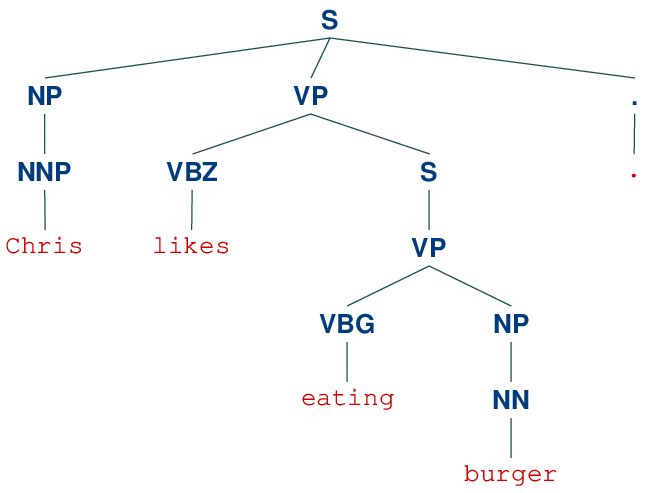

In [7]:
jupyter_draw_nltk_tree(tree)

If you see a parse tree above and no errors, great :). If not, it doesn't really matter either.


---

## Application: Text Obfuscation

Text obfuscation, also known as text anonymization or text de-identification, is the process of modifying or transforming text data to conceal or remove sensitive or personally identifiable information (PII). The purpose of text obfuscation is to protect the privacy and confidentiality of individuals mentioned in the text while preserving the utility and usefulness of the data for analysis or sharing.

Text obfuscation techniques aim to replace sensitive information with non-sensitive or generic placeholders or to modify the text in a way that makes it difficult to identify individuals or extract sensitive information. Common types of sensitive information that may be obfuscated include names, addresses, phone numbers, email addresses, social security numbers, credit card numbers, and other personally identifiable details.

There are several methods and strategies for text obfuscation, depending on the specific requirements and context. Some commonly used techniques include:

* **Masking:** Replacing sensitive information with generic placeholders or masks. For example, replacing names with pseudonyms or using "XXX" to hide digits of a credit card number.

* **Tokenization:** Replacing sensitive words or phrases with generic tokens or categories. For example, replacing names with "PERSON" or locations with "LOCATION."

* **Generalization:** Replacing specific values with more general or less precise ones. For example, replacing an exact age with an age range, such as "30-40 years old."

* **Perturbation:** Introducing controlled noise or randomization to modify the original data while preserving its statistical properties. This technique is commonly used in privacy-preserving data mining.

* **Sentence-level obfuscation:** Rewriting or paraphrasing sentences to retain the meaning but remove specific details or sensitive information.

Text obfuscation is crucial when handling sensitive data to ensure compliance with privacy regulations and protect the privacy of individuals involved. It allows organizations to share or analyze text data without the risk of exposing sensitive information, enabling data-driven insights while maintaining confidentiality.

In the following, we look at sentence-level obfuscation. Let's assume the example task from the lecture where we want to remove some snippets from a sentence. The motivation was that some parts of a sentence might reveal sensitive information that we want to hide. We use the same example sentence from the lecture *"I stayed at the Kempinski Hotel with Alice."* and we want to remove the information about the Kempinski Hotel. First, let's parse this sentence and have a look at the parse tree.

In [ ]:
text = "I stayed at the Kempinsky Hotel with Alice."

doc = nlp(text)

# Let's consider only the first sentence (in case there are more than 1 sentence)
sentence = list(doc.sents)[0]

# The parse string is some standardized way to "verbalize" parse trees using a nested notation
print(sentence._.parse_string)

# Convert to NLTK representation
tree = Tree.fromstring(sentence._.parse_string)

# Draw parse tree
jupyter_draw_nltk_tree(tree)

It is obvious that we cannot simply remove *"Kempinski"* or *"Kempinski Hotel"* since this would yield a sentence that is no longer well-formed. In the lecture, we made the argument that we need to remove complete constituents to ensure proper sentences. However, we cannot simply remove any constituent containing our target words. For example, removing the noun phrase (NP) *"the Kempinski Hotel"* would yield *"I stayed at with Alive"* which is obviously not a proper sentence. The reasons for this is that this NP *"the Kempinski Hotel"* is part of a prepositional phrase (PP) *"at the Kempinski Hotel"*.

In short, in practice, it is not trivial which constituent to remove. There are 2 goals:
* The constituent should be a small as possible, i.e., we only want to remove is little as possible
* After the removal we need to guarantee a well-formed sentence (even if it will sound a bit odd, at least it will be grammatically correct).

To keep it simple, let's assume that we can always safely remove prepositional phrases; this will be good enough for our example here.

### Understanding the Parser Output

If you check the [Benepar Docs](https://pypi.org/project/benepar/), you can see that we can loop over all constituents as follows:


In [ ]:
target_word = "Kempinski"

# Loop over all consituents
for span in sentence._.constituents:
    
    # Extract the individual words of a consituent (for filtering)
    words = [ t.text for t in span]
    
    # Let's focus only on the constituents that contain our target word "Kempinsky" 
    if target_word in words:
        print(span, span._.labels)

This gives us all the constituents that contain our target word *"Kempinski"* at all levels of the parse tree. Given our assumption, we know that we can remove any prepositional phrase (PP) to ensure proper sentences. While this example contains only one PP with our target word, in general, there could be more. So let's fetch them all and select the shortest one. We only need to change the code cell above a bit to:

In [ ]:
target_word = "Kempinsky"

candidates_spans = set()

# Loop over all consituents
for span in sentence._.constituents:
    
    # Extract the individual words of a consituent (for filtering)
    words = [ t.text for t in span]
    
    # Let's focus only on the constituents that contain our target word "Kempinsky" 
    if target_word in words:
        try:
            if span._.labels[0] == 'PP':
                candidates_spans.add(span)
        except:
            pass
            
# In case of multiple constuents, pick the shortest one (Python makes such things very easy)
shortest_candidate_span = min(candidates_spans, key=len)

print("Shortest PP containg target word '{}': {}".format(target_word, shortest_candidate_span))

### Removing the Selected Constituent

Now that we know which constituents we want to remove, we can do so by identifying the indices of all tokens that are part of this constituent. Lastly, we can remove all the tokens associated with these indices to remove the prepositional phrase. Note that we first create the obfuscated sentence as a string and then analyze this string again using spaCy. In principle, we could directly modify the spaCy object for the original sentence, but a re-analysis of the new sentence is "cleaner" as it incorporates all possible changes in the analysis. At the very least, it ensures that all word/tokens have consecutive indices again.


In [ ]:
# Extract indices of the tokens that are part of the constituent we want to remove
obsolete_indices = [ token.i for token in shortest_candidate_span ]

# Create a new sentence from the original sentence but ignoring the obsolete indicies
sentence_obfuscated = ' '.join([ token.text for token in doc if token.i not in obsolete_indices ])

# Re-analyze the new sentence with spaCy
doc_obfuscated = nlp(sentence_obfuscated)

# Print the obfuscated sentence
print(doc_obfuscated)

As you can see, the resulting sentence is still grammatically correct but no longer contains the part we considered as sensitive information. Of course, if we would further consider *"Alice"* as sensitive information as well, we could apply the same process again and end up with the sentence *"I stayed"*. While still grammatically correct, there naturally will come a time when removing more and more parts from a sentence will make it meaningless.

### Discussion

The example of sentence-level obfuscation to remove snesitive parts from a sentence was of course very simplified. The focus was on the motivation and showcasing a simple example to get the basic idea of how to use constituency parsing for this task. For a practical application, there a several other important considerations:

* We assumed that we can always safely remove prepositional phrases (PP) which might not be the case in all circumstances. In general, the question is what are the rules that state which constituents can be removed to ensure proper sentences.

* Here, we only removed constituents. However, this can often lead to sentences that, although grammatically correct, may read a bit odd. This also means that it can be easier to spot that a sentence has been obfuscated. A more sophisticated approach would be to replace constituents with an alternative. From example, we could generate a sentence "*I stayed in a hotel in Singapore with Alice*" by utilizing some background knowledge that *"Kempinski Hotel"* in this sentence is referring to the hotel with that name in Singapore.

* When it comes to replacing constituents, we can easily swap constituents of the same type and preserve the grammatical correctness. For example, we can replace a PP with any other PP and get a proper sentence. Of course, the meaning might be weird. So while *"I stayed beyond the scope of the lecture with Alice"* is a grammatically correct sentence, it arguably does not make sense.


---

## Summary

Constituency parsing is a natural language processing technique that analyzes the grammatical structure of a sentence by determining the syntactic relationships between words. It involves dividing a sentence into constituent phrases and representing them in a hierarchical structure called a parse tree. The root of the tree represents the entire sentence, while the branches and leaves represent the constituents and words, respectively.

Constituency parsing has several practical uses in various NLP applications. Here are some key applications:

* **Syntax Analysis:** Constituency parsing helps in understanding the syntactic structure of a sentence by identifying noun phrases, verb phrases, prepositional phrases, and other constituents. This information is valuable for tasks such as grammar checking, syntactic analysis, and language understanding.

* **Machine Translation:** Constituency parsing aids in improving the accuracy of machine translation systems. By understanding the syntactic structure of the source and target sentences, parsers can help identify corresponding phrases and improve alignment, resulting in more accurate translations.

* **Information Extraction:** Constituency parsing can assist in extracting structured information from unstructured text. By identifying the syntactic constituents, such as subject-verb-object relationships or nested phrases, it becomes easier to extract relevant information, such as entities, relations, and events.

* **Sentiment Analysis:** Analyzing the syntactic structure of sentences through constituency parsing can enhance sentiment analysis. By identifying the sentiment-bearing constituents, such as subject or verb phrases, parsers can provide finer-grained sentiment analysis and improve the overall accuracy of sentiment classification.

* **Question Answering:** Constituency parsing helps in understanding the structure of questions and mapping them to corresponding answers. By analyzing the question constituents and their relationships, parsers can aid in identifying relevant information and generate accurate responses.

* **Summarization and Text Generation:** Constituency parsing can be useful in text summarization and generation tasks. By understanding the sentence structure, parsers can identify key phrases or clauses, which can guide the selection of important information for summarization or assist in generating coherent and grammatically correct text.

Constituency parsing is a fundamental technique in NLP that provides insights into the syntactic structure of sentences. Its practical applications span across various domains, enabling improved language understanding, information extraction, machine translation, sentiment analysis, question answering, and text generation.